### [총 사용모델 : 3가지]
* 1) monologg/koelectra-base-v3-discriminator
* 2) bert
* 3) 

## 1. 라이브러리 및 데이터 불러오기

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, AutoTokenizer, AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from sklearn.metrics import classification_report
# GPU 사용
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/train_data2.xlsx')
test = pd.read_excel('/content/drive/MyDrive/test_data.xlsx')

Mounted at /content/drive


## 2. 데이터 전처리

In [ ]:
#모델에 맞게 형식 변환  
data['doc'] = "[CLS] " + data['doc'] + " [SEP]"
# data[data['doc'].notnull()]
data

In [ ]:
def convert_input(sentences):
    tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 200
    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # 어텐션 마스크 초기화
    attention_masks = []
    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

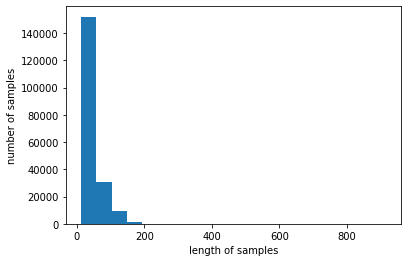

In [ ]:
plt.hist([len(doc) for doc in data['doc']], bins = 20)
plt.xlabel('length of samples'), plt.ylabel('number of samples');

In [ ]:
input_ids, attention_masks = convert_input(data.doc)

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

## 3. 모델 생성

In [ ]:
# 훈련셋과 검증셋으로 분리
train_x, val_x, train_y, val_y = train_test_split(input_ids, data.label.values, random_state=1004, test_size=0.2)
train_mask, val_mask, _, _ = train_test_split(attention_masks, input_ids, random_state=1004, test_size=0.2)

In [ ]:
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
train_mask = torch.tensor(train_mask)
val_x = torch.tensor(val_x)
val_y = torch.tensor(val_y)
val_mask = torch.tensor(val_mask)				

In [ ]:
batch_size = 32
train_data = TensorDataset(train_x, train_mask, train_y)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_x, val_mask, val_y)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


In [ ]:
# 분류를 위한 koelectra_v3 모델 생성
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator")
model.cuda()

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
epochs = 10
total_steps = len(train_dataloader) * epochs

optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. 모델 학습

In [ ]:
# 정확도 계산 함수
def get_accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    accuracy = np.sum(pred == labels) / len(labels)
    report = classification_report(labels, pred)
    return accuracy, report

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 그래디언트 초기화
model.zero_grad()
loss_list, acc_list = [], []
for epoch in tqdm(range(0, epochs)):
    # 로스 초기화
    total_loss = 0
    # 훈련모드
    model.train()
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
#         batch[-1] = torch.Tensor(pd.get_dummies(batch[-1]).values)
#         b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # Forward 수행                
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        # Backward 수행으로 그래디언트 계산
        loss.backward()
        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()
        # 스케줄러로 학습률 감소
        scheduler.step()
        # 그래디언트 초기화
        model.zero_grad()
    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_train_loss)            
   
    # 평가모드
    model.eval()
    # 변수 초기화
    eval_loss, eval_accuracy, nb_eval_steps = 0, 0, 0
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            # 로스 구함
        logits = outputs[0]
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        accuracy, report = get_accuracy(logits, label_ids)
        eval_accuracy += accuracy
        nb_eval_steps += 1
    acc_list.append(round(eval_accuracy/nb_eval_steps, 2))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
PATH = '/content/drive/MyDrive/'
torch.save(model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, PATH + 'all.tar')  

## 5. 모델 검증

Accuracy : 0.85


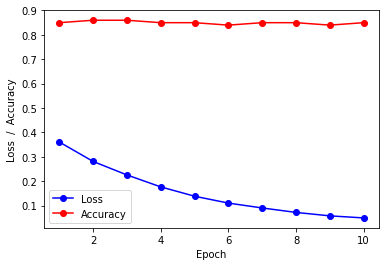

In [ ]:
epoch = range(1, epochs+1) 
plt.plot(epoch, loss_list,'-bo', label='Loss')
plt.plot(epoch, acc_list, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Accuracy : {round(eval_accuracy/nb_eval_steps, 2)}')

In [ ]:
# f1-score
print(report)

## 6. 전이학습

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
PATH = '/content/drive/MyDrive/'
model = torch.load(PATH + 'model.pt')  # 모델 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/Koelectra_base.pt'))

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


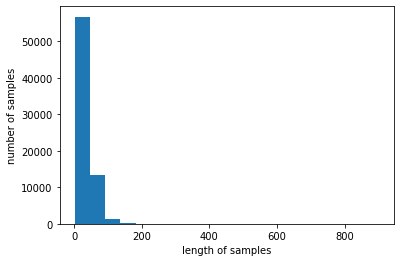

In [ ]:
plt.hist([len(doc) for doc in test['doc']], bins = 20)
plt.xlabel('length of samples'), plt.ylabel('number of samples');

In [ ]:
def test_sentences(sentences):
    model.eval()
    # 문장을 입력 데이터로 변환
    input_ids, attention_masks = convert_input(sentences)
    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    # 그래디언트 계산 안함
    with torch.no_grad():     
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    pred = np.argmax(logits, axis=1)
    return pred     

In [ ]:
for idx in tqdm(range(len(test))):
    pred = test_sentences([test.doc[idx]])
    test.loc[idx, 'predicted'] = pred

test

  0%|          | 0/71834 [00:00<?, ?it/s]

,id,year,doc,content,ecnt,scnt,gcnt,predicted
0,1,2020,원수가 다니겠다고 하면 도시락 싸 들고 환영할 회사 중소기업의 흔한 사건사고 단점 ...,장점 꼰대 문화가 별로 없고 변화와 발전 추구함 투자를 많이 받고 있기 때문에 사...,0,2,3,0
1,1,2020,앞으로도 더 성장 할 가능성이 높은 회사,장점 직원들에게 많은 기회를 준다 한가지만 보지 않고 다양한 분야에서 어떻게 인재가...,0,0,2,1
2,1,2020,블리츠웨이 300 꿈의 장난감 볼트론 피규어로 매출 100억원 기대,피규어 전문제작사 블리츠웨이가 출시 예정인 볼트론이 사전예약 첫 날 자체 예약 최고...,0,0,0,1
3,1,2020,배용준도 투자한 블리츠웨이 코스닥 예비심사 통과 정밀 피규어 최초 상장 기대,피규어 개발 및 제작 전문 기업 블리츠웨이가 코스닥 상장을 위한 예비 심사를 통과했...,0,0,0,1
4,1,2020,대신밸런스제9호스팩 블리츠웨이와 합병 승인 12월 코스닥 상장,대신밸런스제9호스팩은 피규어 개발 제작 전문 기업 블리츠웨이 와 합병상장을 위한 ...,0,0,0,1
...,...,...,...,...,...,...,...,...
71829,1382,2020,레미콘제조업체로 현상유지만 하고있음앞으로 전망은 낙관적이지 않음,장점 공장은 장점 이 없고 서울본사는 근무할만 함빽있는 사람은 다닐만함 단점 빽없는...,0,0,3,0
71830,1382,2020,개 법인이 같이 운영되고 있음 그중 개는 죽쑤는중 덕원이랑 모헨즈가 이끌어감 덕원은...,장점 중소기업치고 연봉이 높은편 대신 성과금이 없다 본사에입사하면 워라밸 가능함 공...,0,0,1,1
71831,1382,2021,차산업 특성상 육체노동의 불가피함 진급욕심가득한 몇몇으로 인해 피해보는 직원 속출,장점 직원들 대부분의 성향이 밝은 쪽이 많음 적응하는 기간이 오래걸리지않고 형동생으...,0,1,1,0
71832,1382,2021,사람을 가볍게 여기는 회사 임원진들만 잘먹고 잘사는 회사,장점 월급이 밀리지 않고 제 때 들어오는것이 이 회사의 유일한 장점 단점 정해놓은...,0,0,1,0


In [ ]:
test.to_csv("predict_koelec3.csv") # header=False, index=False

In [ ]:
# predict= pd.read_csv("./kopredict_koelec3.csv", encoding='CP949')
# predict.head(10)